## Reference: Deeplearning.ai by Andrew Ng 

## A: The value of S1 would be 2 since there are 2 feature and S3 would be 1 since the output is binary.

In [23]:
from collections import deque
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def get_cost_w_reg(A3, Y, parameters, lambd):
  
    m  = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    cross_entropy_cost     = np.squeeze(- 1 * np.sum(np.multiply(Y, np.log(A3)) \
                                                     + np.multiply((1 - Y), np.log(1 - A3)), axis=1) / Y.shape[1])
    
    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2))) / (2 * m) 
    
    
    return cross_entropy_cost + L2_regularization_cost

In [11]:
def init(layer_dims):

    parameters = {}
    
    for l in range(1, len(layer_dims)):
        
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
          
    return parameters

def forward_prop_activation(A_prev, W, b, activation):
    
    Z            = np.dot(W, A_prev) + b
    linear_cache = (A_prev, W, b)
    
    if activation == "relu":
        
        A                = np.maximum(Z, 0)
        activation_cache = Z
        
    elif activation == "sigmoid":
        
        A                = (1 + np.exp(-Z))**(-1)
        activation_cache = Z
        
    elif activation == "tanh":
        
        activation_cache = Z
        e_z              = np.exp(Z)
        e_nz             = np.exp(-Z)
        A                = (e_z - e_nz)/(e_z + e_nz)


    cache = (linear_cache, activation_cache)
    
    return A, cache


def forward_prop(X, parameters, activations):

    caches = []
    A      = X
    L      = len(parameters) // 2 
    
    for l in range(1, L):
        
        A_prev     = A
        activation = activations.popleft()
        A, cache   = forward_prop_activation(A_prev, parameters["W" + str(l)],parameters["b" + str(l)], activation)
        caches.append(cache)

    activation = activations.popleft()
    AL, cache  = forward_prop_activation(A, parameters["W" + str(l + 1)], parameters["b" + str(l + 1)], activation)
    caches.append(cache)
    
    return AL, caches

In [12]:
def backprop(dZ, cache, lambd):

    A_prev, W, b = cache
    m            = A_prev.shape[1]
    
    dW           = (1/m) * np.dot(dZ, A_prev.T) + (lambd * W) / m
    db           = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev      = np.dot(W.T, dZ)
    

    return (dA_prev, dW, db)


def backprop_activation(dA, cache, activation, lambd):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        Z          = activation_cache
        dZ         = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    
        
    elif activation == "sigmoid":
        
        Z  = activation_cache
        s  = np.power((1 + np.exp(-Z)),-1)
        dZ = dA * s * (1 - s)
   
        
    elif activation == "tanh":        
        Z    = activation_cache
        s    = (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z))    
        A    = Z * (1 - np.power(s, 2))
    
    dA_prev, dW, db = backprop(dZ, linear_cache, lambd)
    
    return (dA_prev, dW, db)

def get_backprop_gradients(AL, Y, caches, activations, lambd):

    grads = {}
    L     = len(caches)
    m     = AL.shape[1]
    Y     = Y.reshape(AL.shape)
        
    dAL   = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    
    activation    = activations.pop()
    current_cache = caches[L-1]
    
    grads["dA" + str(L-1)],\
    grads["dW" + str(L)],\
    grads["db" + str(L)] = backprop_activation(dAL, current_cache, activation, lambd)
        
    for l in reversed(range(L-1)):
        
        activation    = activations.pop()
        current_cache = caches[l]
        
        dA_prev_temp, dW_temp, db_temp = backprop_activation(grads["dA" + str(l + 1)],\
                                                                    current_cache, activation, lambd)
        grads["dA" + str(l)]     = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads
    
    
def backward_w_reg(X, Y, cache, lambd):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2) = cache
    
    dZ2 = A2 - Y
    dW2 = 1. / m * np.dot(dZ2, A1.T) + (lambd * W2) / m
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T) + (lambd * W1) / m
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dA2": dA2,"dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [13]:
def update(parameters, grads, learning_rate):

    L = len(parameters) // 2 
    
    for l in range(L):
        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                        learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                        learning_rate * grads["db" + str(l + 1)]
        
    return parameters


def train_model(X, Y, config):
            
    parameters = init(config["layers_dims"])
    
    for i in range(0, config["num_iterations"]):
        
        fact       = deque(config["activations"].copy())
        AL, caches = forward_prop(X, parameters, fact)          
        cost       = get_cost_w_reg(AL, Y, parameters, config["lambd"])
        bact       = deque(config["activations"].copy())
        grads      = get_backprop_gradients(AL, Y, caches, bact, config["lambd"])
        parameters = update(parameters, grads, config["learning_rate"])
        
        if i % 1000 == 0:  print ("Cost after iteration %i: %f" %(i, cost))
                         
    return parameters


def predict(X, y, parameters, activations):
    
    p              = np.zeros((1,m))
    facts          = deque(activations.copy())
    probas, caches = forward_prop(X, parameters, facts)

    for i in range(0, probas.shape[1]):
        
        if probas[0,i] > 0.5: p[0,i] = 1
        else:                 p[0,i] = 0

    return p


def load():
    
    
    input_data    = pd.read_csv('data/HW5.csv')
    train, test   = train_test_split(input_data, test_size = 0.2)
    
    x_train       = np.array(train.loc[:, ['a', 'b']])
    y_train       = np.array(train.loc[:, ['label']])
    
    x_test        = np.array(test.loc[:, ['a', 'b']])
    y_test        = np.array(test.loc[:, ['label']])
    
    
    
    return x_train, y_train, x_test, y_test

In [14]:
x_train, y_train, x_test, y_test = load()

## B. The accuracy for S = 2 is 73% with lambda 0.5 and 97% with lambda = 500

In [15]:
config = { "activations": ["relu", "sigmoid"], "layers_dims" : [2, 2, 1],
            "learning_rate": 0.0075, "num_iterations" : 3000,
            "print_cost": True,"lambd": 0.5}

parameters        = train_model(x_train.T, y_train.T, config) 
y_test_pred       = predict(x_test.T, y_test.T, parameters, config.get("activations")).T 
accuracy_score(y_test, y_test_pred)

Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.391115
Cost after iteration 2000: 0.359117


0.747

In [16]:
parameters

{'W1': array([[-0.49614893, -0.77022891],
        [-0.63621609, -0.32190759]]),
 'W2': array([[-0.91698623,  0.7138217 ]]),
 'b1': array([[ 0.03989014],
        [-0.03534747]]),
 'b2': array([[0.08445209]])}

## lambda = 500

In [29]:
config = {"activations": ["relu", "sigmoid"], "layers_dims" : [2, 2, 1],
            "learning_rate": 0.0075, "num_iterations" : 3000,
            "print_cost": True,"lambd": 500}

parameters        = train_model(x_train.T, y_train.T, config) 
y_test_pred       = predict(x_test.T, y_test.T, parameters, config.get("activations")).T 
accuracy_score(y_test, y_test_pred)

Cost after iteration 0: 0.693319
Cost after iteration 1000: 0.523287
Cost after iteration 2000: 0.464413


0.979

In [28]:
parameters

{'W1': array([[-0.24860265, -0.5123004 ],
        [ 0.75084355, -0.00124395]]),
 'W2': array([[-0.5698433 ,  0.75442722]]),
 'b1': array([[0.02775391],
        [0.08547043]]),
 'b2': array([[0.0220922]])}

## C. The accuracy for S = 10 is 100% with lambda = 0.5 and 74% with lambda = 500 

In [18]:
config = {
    "activations": ["relu", "sigmoid"],
    "layers_dims" : [2, 10, 1], #  2-layer model
    "learning_rate": 0.0075,
    "num_iterations" : 3000,
    "print_cost": True,
    "lambd": 0.5
}

parameters  = train_model(x_train.T, y_train.T, config)
y_test_pred = predict(x_test.T, y_test.T, parameters, config.get("activations")).T 
accuracy_score(y_test, y_test_pred)

Cost after iteration 0: 0.693806
Cost after iteration 1000: 0.049605
Cost after iteration 2000: 0.013739


0.999

In [19]:
parameters

{'W1': array([[-0.55077971, -0.76099436],
        [-0.36152371, -0.09346549],
        [-0.17603503, -0.24320444],
        [-0.28251728, -0.07297098],
        [-0.08262698, -0.02141725],
        [-0.65783904, -0.16983369],
        [ 0.09517558,  0.24942912],
        [ 0.20888765,  0.54431803],
        [ 0.95332922,  0.15967837],
        [ 0.17114534,  0.02866454]]),
 'W2': array([[-0.94035605,  0.37418498, -0.30047745,  0.29224385,  0.08449863,
          0.68066009, -0.266931  , -0.58308542,  0.97117605,  0.17407018]]),
 'b1': array([[ 0.04313984],
        [-0.01973303],
        [ 0.01346816],
        [-0.01657169],
        [-0.00331261],
        [-0.0399877 ],
        [-0.00238802],
        [-0.00610014],
        [ 0.09658692],
        [ 0.01705597]]),
 'b2': array([[-0.01104839]])}

## Setting a high lambda

In [33]:
config = {
    "activations": ["relu", "sigmoid"],
    "layers_dims" : [2, 10, 1], #  2-layer model
    "learning_rate": 0.0075,
    "num_iterations" : 3000,
    "print_cost": True,
    "lambd": 500
}

parameters  = train_model(x_train.T, y_train.T, config)
y_test_pred = predict(x_test.T, y_test.T, parameters, config.get("activations")).T 
accuracy_score(y_test, y_test_pred)

Cost after iteration 0: 0.695011
Cost after iteration 1000: 0.654314
Cost after iteration 2000: 0.651400


0.747

In [35]:
parameters

{'W1': array([[-1.95040110e-05,  8.07721180e-06],
        [-5.30872339e-02, -8.83093145e-02],
        [-7.65599550e-14,  3.18206948e-12],
        [-2.07695421e-03, -3.43965044e-03],
        [-2.38263393e-03, -3.95139184e-03],
        [-4.03199479e-06,  1.66886207e-06],
        [ 1.33921391e-06,  3.90191742e-07],
        [ 1.68743713e-03, -1.55409451e-04],
        [-1.22472288e-01, -2.03752742e-01],
        [-4.86712735e-05,  2.01483870e-05]]),
 'W2': array([[ 1.60461971e-05, -1.05405964e-01, -1.37457003e-12,
         -4.10613407e-03, -4.71700442e-03,  3.31758276e-06,
          1.92446883e-06,  1.98258249e-03, -2.43196958e-01,
          4.00460211e-05]]),
 'b1': array([[-2.60617973e-04],
        [ 1.15538398e-01],
        [-2.35373103e-04],
        [ 4.29141017e-03],
        [ 5.01316378e-03],
        [-5.38563715e-05],
        [ 5.05891603e-04],
        [ 8.57900171e-03],
        [ 2.66827197e-01],
        [-6.50194286e-04]]),
 'b2': array([[0.31134879]])}

## Part D

### The data is not linearly seperable. Part (ii) with 2 neurons in layer 2 could reach 74% accuracy where as part (iii) with 10 neurons in layer 3 could classify everything correctly. This makes sense as the more neurons there are, the higher the variance will be and more flexible the model will be.

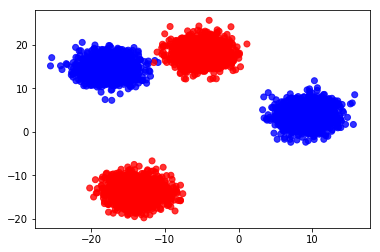

In [26]:
input_data    = pd.read_csv('data/HW5.csv')
color         = ['blue' if i == 1 else 'red' for i in input_data['label']]

plt.scatter(input_data['a'], input_data['b'], color=color, alpha = 0.8)